In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Получение данных

In [47]:
!wget -P /content/data/ https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data

--2024-12-06 12:14:17--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40697 (40K) [application/x-www-form-urlencoded]
Saving to: ‘/content/data/parkinsons.data.4’

parkinsons.data.4   100%[===================>]  39.74K  --.-KB/s    in 0.1s    

2024-12-06 12:14:18 (306 KB/s) - ‘/content/data/parkinsons.data.4’ saved [40697/40697]



In [48]:
df = pd.read_csv('data/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

# Предобработка

In [50]:
# Деление на фичи и лейблы
X = df.iloc[:,(df.keys() != 'name') & (df.keys() != 'status')]
y = df['status']

In [68]:
y.value_counts()

,count
status,
1,147
0,48


In [51]:
# Нормализация
X = Normalizer().fit_transform(X=X)

# Деление на тест-трейн

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,stratify=y)

# Подбор гиперпараметров

In [58]:
X_train_hp, X_val_hp, y_train_hp, y_test_hp = train_test_split(X_train,y_train,stratify=y_train)

In [70]:
hyperparametres_for_tree = {
    'learning_rate': np.linspace(0,1,20)
    ,'min_split_loss': np.linspace(0,100,20)
    ,'max_depth': np.arange(5,100,10)

    ,'min_child_weight': np.arange(0,10,.5)
    ,'max_delta_step': np.arange(0,10,.5)
    ,'subsample': np.linspace(0,1,20)
    # ,'sampling_method': ['uniform','gradient_based']
    ,'colsample_bytree': np.linspace(0,1,20)
    ,'colsample_bylevel': np.linspace(0,1,20)
    ,'colsample_bynode': np.linspace(0,1,20)
    ,'lambda': np.arange(0,10,.5)
    ,'alpha': np.arange(0,10,.5)
    ,'scale_pos_weight': [1,48/147]
    ,'max_leaves': np.arange(0,20,1)
    # ,'max_bin': np.arange(256,1024,64)
    ,'num_parallel_tree': np.arange(1,100,10)
}

clf = xgb.XGBClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=hyperparametres_for_tree, n_iter=500, cv=5)
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
        84.21052632,  89.47368421,  94.73684211, 100.        ]),
                                        'num_parallel_tree': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                                        'scale_pos_weight': [1,
                                                             0.32653061224489793],
                                        'subsample': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])})

In [74]:
print(random_search.best_score_)
random_search.best_params_

0.853225806451613


{'subsample': 0.7368421052631579,
 'scale_pos_weight': 1,
 'num_parallel_tree': 91,
 'min_split_loss': 0.0,
 'min_child_weight': 0.0,
 'max_leaves': 0,
 'max_depth': 5,
 'max_delta_step': 1.5,
 'learning_rate': 0.10526315789473684,
 'lambda': 2.0,
 'colsample_bytree': 0.2631578947368421,
 'colsample_bynode': 0.42105263157894735,
 'colsample_bylevel': 0.10526315789473684,
 'alpha': 3.5}

# Обучение модели

In [75]:
clf = xgb.XGBClassifier(**random_search.best_params_)

In [76]:
clf.fit(X_train,y_train,eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.50552
[1]	validation_0-logloss:0.49233
[2]	validation_0-logloss:0.47983
[3]	validation_0-logloss:0.46956
[4]	validation_0-logloss:0.45917
[5]	validation_0-logloss:0.44996
[6]	validation_0-logloss:0.44226
[7]	validation_0-logloss:0.43457
[8]	validation_0-logloss:0.42780
[9]	validation_0-logloss:0.42158
[10]	validation_0-logloss:0.41495
[11]	validation_0-logloss:0.40905
[12]	validation_0-logloss:0.40363
[13]	validation_0-logloss:0.39852
[14]	validation_0-logloss:0.39370
[15]	validation_0-logloss:0.38981
[16]	validation_0-logloss:0.38560
[17]	validation_0-logloss:0.38169
[18]	validation_0-logloss:0.37827
[19]	validation_0-logloss:0.37465
[20]	validation_0-logloss:0.37079
[21]	validation_0-logloss:0.36750
[22]	validation_0-logloss:0.36462
[23]	validation_0-logloss:0.36207
[24]	validation_0-logloss:0.35905
[25]	validation_0-logloss:0.35635
[26]	validation_0-logloss:0.35405
[27]	validation_0-logloss:0.35160
[28]	validation_0-logloss:0.34937
[29]	validation_0-loglos

XGBClassifier(alpha=3.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.10526315789473684,
              colsample_bynode=0.42105263157894735,
              colsample_bytree=0.2631578947368421, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.0,
              learning_rate=0.10526315789473684, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=1.5, max_depth=5, max_leaves=0,
              min_child_weight=0.0, min_split_loss=0.0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

# Проверка модели

In [77]:
y_pred = clf.predict(X_test)

In [78]:
print('Точность модели: %.2f' % accuracy_score(y_test,y_pred))

Точность модели: 0.90


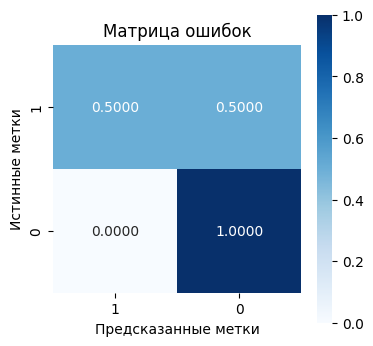

In [79]:
def show_confusion_matrix(y_true,y_pred):
    y_pred,y_true = np.array(y_pred), np.array(y_true)
    n = len(pd.unique(y_true))
    plt.figure(figsize=(n*2,n*2))
    confusion_normalized = confusion_matrix(y_true,y_pred,normalize='true')
    axis_labels = pd.unique(y_true)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test,y_pred)